#### Why Use Vertex AI Instead of a Notebook?

With Vertex AI, you can choose the right machine type, from CPUs to powerful GPUs and TPUs, making it easier to scale and train models faster. It also integrates seamlessly with Google Cloud tools, so you don’t have to worry about setup and maintenance.

Unlike a local notebook, Vertex AI handles infrastructure automatically—no need to install dependencies, manage drivers, or configure networking. It provides a managed environment where resources are optimized, updates are handled by Google, and you can focus entirely on your model.

If you just want to use Vertex AI’s power without fully moving your workflow, you can connect Google Colab to Vertex AI via API calls, run models remotely, or even use Gemini for advanced AI capabilities.

# Reading data from Bigquery

In [4]:
# Import the BigQuery module from Google Cloud
from google.cloud import bigquery

# Create a BigQuery client without specifying a project
# In Vertex AI, the environment automatically uses the project where the notebook is running
client = bigquery.Client(project="talk-gdg")

In [5]:
# Define the SQL query to retrieve all data from the "house" table in the "house_dataset" dataset
query = """
SELECT * 
FROM `talk-gdg.house_dataset.house`
"""

# Execute the query and convert the results into a Pandas DataFrame
df = client.query(query).to_dataframe()

# Display the first few rows of the retrieved data
df.head() # Show first rows of the dataset

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3980300371,20140926T000000,142000.0,0,0.00,290,20875,1.0,0,0,...,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850
1,2420069251,20150225T000000,262000.0,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
2,3421079032,20150217T000000,75000.0,1,0.00,670,43377,1.0,0,0,...,3,670,0,1966,0,98022,47.2638,-121.906,1160,42882
3,5702500050,20141104T000000,280000.0,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549
4,745000005,20140825T000000,145000.0,1,0.75,480,9750,1.0,0,0,...,4,480,0,1948,0,98146,47.4982,-122.362,1550,9924


#  Initial imports and configurations


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
pip install xgboost


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
# Importing Machine Learning Libraries

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# EDA - Exploratory Data Analysis

## Analyzing Variables


In [9]:
# Returns the number of rows and columns in the dataset
df.shape

(21613, 21)

We can see that this dataset contains 21,613 rows and 21 columns.

In [10]:
# Display dataset information, including:
# - Number of non-null values per column
# - Data types of each column
# - Memory usage

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  Int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  Int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  Int64  
 6   sqft_lot       21613 non-null  Int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  Int64  
 9   view           21613 non-null  Int64  
 10  condition      21613 non-null  Int64  
 11  grade          21613 non-null  Int64  
 12  sqft_above     21613 non-null  Int64  
 13  sqft_basement  21613 non-null  Int64  
 14  yr_built       21613 non-null  Int64  
 15  yr_renovated   21613 non-null  Int64  
 16  zipcode        21613 non-null  Int64  
 17  lat            21613 non-null  float64
 18  long  

Through `.info`, we can understand the types of our data, which columns we have, and whether there are any null values.

We can use pandas to obtain summary statistics of our data. The `.describe` method will also give us the number of values.

In [11]:
# Overview of Descriptive Statistics for Numerical Variables
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.0,2.161300e+04,21613.0,21613.000000,21613.0,21613.0,21613.000000,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.000000,21613.000000,21613.0,21613.0
mean,4580301520.864988,5.400881e+05,3.370842,2.114757,2079.899736,15106.967566,1.494309,0.007542,0.234303,3.40943,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2876565571.312057,3.671272e+05,0.930062,0.770163,918.440897,41420.511515,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.67924,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1000102.0,7.500000e+04,0.0,0.000000,290.0,520.0,1.000000,0.0,0.0,1.0,1.0,290.0,0.0,1900.0,0.0,98001.0,47.155900,-122.519000,399.0,651.0
25%,2123049194.0,3.219500e+05,3.0,1.750000,1427.0,5040.0,1.000000,0.0,0.0,3.0,7.0,1190.0,0.0,1951.0,0.0,98033.0,47.471000,-122.328000,1490.0,5100.0
50%,3904930410.0,4.500000e+05,3.0,2.250000,1910.0,7618.0,1.500000,0.0,0.0,3.0,7.0,1560.0,0.0,1975.0,0.0,98065.0,47.571800,-122.230000,1840.0,7620.0
75%,7308900445.0,6.450000e+05,4.0,2.500000,2550.0,10688.0,2.000000,0.0,0.0,4.0,8.0,2210.0,560.0,1997.0,0.0,98118.0,47.678000,-122.125000,2360.0,10083.0
max,9900000190.0,7.700000e+06,33.0,8.000000,13540.0,1651359.0,3.500000,1.0,4.0,5.0,13.0,9410.0,4820.0,2015.0,2015.0,98199.0,47.777600,-121.315000,6210.0,871200.0


#### Let's analyze:

1. Column `price` (Price)

- Mean: Indicates that, on average, house prices are around ~540,088 USD.
- Standard deviation (std): ~367,127 USD, showing a large variation in house prices, suggesting that the dataset includes both luxury and more affordable homes.
- Min and Max: Prices range from 75,000 to 7,700,000 USD (very high value), reinforcing the diversity of property types in the dataset.
- **The high standard deviation and the large difference between the minimum and maximum values suggest the presence of outliers. Consider investigating this further in the future.**

2. Columns `bedrooms` and `bathrooms` (Bedrooms and Bathrooms)

- Min: Both have a minimum value of 0, which could be problematic. A value of 0 for bathrooms does not make sense for a house, indicating possible anomalies or non-residential properties.
- Max: bedrooms goes up to 33, an extremely high number for a typical home, suggesting a potential outlier or data entry error.
- For values of 0, consider checking whether they are valid data points.

3. Columns `sqft_living` and `sqft_lot` (Square Footage of Living Area and Lot)

- Mean: The average living area (sqft_living) is 2,079 sqft, and the average lot size (sqft_lot) is 15,106 sqft.
- Standard Deviation: Both show high variation, especially sqft_lot, suggesting a large diversity in property sizes.
- Min and Max: sqft_living ranges from 290 to 13,540 sqft. Meanwhile, sqft_lot has a very wide range, from 520 to 1,651,359 sqft, indicating the presence of exceptionally large properties, such as farms or estates.

4. Columns `floors`, `waterfront`, and `view`

- Floors: Ranges from 1 to 3.5, indicating multi-story homes. The mean is 1.5, suggesting that most houses have one or two floors.
- Waterfront: The mean of 0.0075 shows that very few homes are near the water. Most values are likely 0.
- View: The mean and standard deviation suggest that most houses do not have a high-quality view.

5. Columns `grade` and `condition` (Quality and Condition)

- Grade: Ranges from 1 to 13, with a mean of 7.7. This suggests that most homes are of average to above-average quality.
- Condition: Ranges from 1 to 5, with a mean of 3.4, indicating that the overall condition of the houses is reasonably good.

**Interesting to note that we have decimal values for bathrooms. This highlights an important step in exploratory data analysis: researching to understand our data.**

In the U.S., bathrooms are counted differently:

- 0.5 → Half-bath (sink + toilet, no shower/tub)
- 0.75 → Three-quarter bath (sink + toilet + shower, no bathtub)
- 1.5 → One full bath + one half-bath

This explains why we see values like 2.25—it's a mix of full and partial bathrooms. 

A full bathroom is made up of four parts: a sink, a shower, a bathtub, and a toilet. Each utility is counted as one-quarter.

## Checking for Null Values

In [12]:
# Step 1: Count the number of missing values in each column
total_nulos = df.isnull().sum()

# Step 2: Calculate the percentage of missing values
percentual_nulos = (total_nulos / len(df)) * 100

# Step 3: Create a DataFrame with the results
dados_nulos = pd.DataFrame({'Total': total_nulos, 'Percentual': percentual_nulos})

# Step 4: Sort by the highest number of missing values
dados_nulos = dados_nulos.sort_values(by='Total', ascending=False)

# Display the top 20 columns with missing values
dados_nulos.head(20)

,Total,Percentual
id,0,0.0
grade,0,0.0
sqft_living15,0,0.0
long,0,0.0
lat,0,0.0
zipcode,0,0.0
yr_renovated,0,0.0
yr_built,0,0.0
sqft_basement,0,0.0
sqft_above,0,0.0


# Data Cleaning & Transformation


## Removing duplicate Values

In [64]:
# Removing duplicate rows from the dataset
df = df.drop_duplicates()

df.info() # Display dataset information after removing duplicates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  Int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  Int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  Int64  
 6   sqft_lot       21613 non-null  Int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  Int64  
 9   view           21613 non-null  Int64  
 10  condition      21613 non-null  Int64  
 11  grade          21613 non-null  Int64  
 12  sqft_above     21613 non-null  Int64  
 13  sqft_basement  21613 non-null  Int64  
 14  yr_built       21613 non-null  Int64  
 15  yr_renovated   21613 non-null  Int64  
 16  zipcode        21613 non-null  Int64  
 17  lat            21613 non-null  float64
 18  long  

## Handling Missing Values

Handling missing values is a step that must be done carefully.

Removing missing values is not always the best option. It is crucial to understand the origin of these values and the context of the dataset before making any decisions.

⚠ Caution: Removing too many rows with missing values can result in the loss of important information and negatively impact your analysis.

Investigate why the value is missing. Depending on the situation, you can decide between:

- Delete: Completely remove rows with missing values (only if the missing data does not carry any relevant information).
- Fill: Replace missing values with the mean, median, or another appropriate value (imputation). If the goal is to build a Machine Learning model, handle missing values carefully.

Missing values should only be removed when their absence has no significance. For example, in the yr_renovated column, NaN values originally indicated missing renovation years. Instead of removing them, I replaced them with 0 using fillna(0), assuming that if no value was recorded, the house was never renovated. This decision was based on the likelihood that the field was optional in the form, and an empty entry implied no renovation.

By replacing NaN with 0, the data more accurately reflects reality and avoids unnecessary data loss.

In [65]:
# # Preenchendo os valores nulos da coluna 'yr_renovated' com 0
# df['yr_renovated'].fillna(0, inplace=True)

## Creating New Columns?

Suggestion: Create a boolean column to indicate whether a house was renovated or not (based on the yr_renovated column). Renovation data is valuable and can be useful for future analysis and modeling.


In [13]:
# Define a function to convert values to boolean
# If yr_renovated is not 0, it means the house was renovated → 1 (True)
# If yr_renovated is 0, the house was never renovated → 0 (False)

def converter_para_booleana(valor):
    if valor != 0:
        return 1
    else:
        return 0

# Apply the function to create a new column
df['renovated'] = df['yr_renovated'].apply(converter_para_booleana)

df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renovated
0,3980300371,20140926T000000,142000.0,0,0.00,290,20875,1.0,0,0,...,290,0,1963,0,98024,47.5308,-121.888,1620,22850,0
1,2420069251,20150225T000000,262000.0,1,0.75,520,12981,1.0,0,0,...,520,0,1920,0,98022,47.2082,-121.995,1340,12233,0
2,3421079032,20150217T000000,75000.0,1,0.00,670,43377,1.0,0,0,...,670,0,1966,0,98022,47.2638,-121.906,1160,42882,0
3,5702500050,20141104T000000,280000.0,1,0.00,600,24501,1.0,0,0,...,600,0,1950,0,98045,47.5316,-121.749,990,22549,0
4,745000005,20140825T000000,145000.0,1,0.75,480,9750,1.0,0,0,...,480,0,1948,0,98146,47.4982,-122.362,1550,9924,0


In [14]:
# Display the last 5 rows
df.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renovated
21608,4139900180,20150420T000000,2340000.0,4,2.50,4500,35200,1.0,0,0,...,4500,0,1988,0,98006,47.5477,-122.126,4760,35200,0
21609,6762700020,20141013T000000,7700000.0,6,8.00,12050,27600,2.5,0,3,...,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800,1
21610,7237501190,20141010T000000,1780000.0,4,3.25,4890,13402,2.0,0,0,...,4890,0,2004,0,98059,47.5303,-122.131,5790,13539,0
21611,9208900037,20140919T000000,6885000.0,6,7.75,9890,31374,2.0,0,4,...,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730,0
21612,9831200500,20150304T000000,2479000.0,5,3.75,6810,7500,2.5,0,0,...,6110,700,1922,0,98102,47.6285,-122.322,2660,7500,0


As we can see, for the year 1987, it means the house was renovated in that year. In the new column, it has been converted to 1, indicating that the house was renovated."

In the sqft_basement column, we notice many zeros, meaning some houses do not have a basement. We can create a new boolean column to indicate whether a house has a basement or not. If the value is 0, it means there is no basement.

In [15]:
df['basement'] = df['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,basement
0,3980300371,20140926T000000,142000.0,0,0.00,290,20875,1.0,0,0,...,0,1963,0,98024,47.5308,-121.888,1620,22850,0,0
1,2420069251,20150225T000000,262000.0,1,0.75,520,12981,1.0,0,0,...,0,1920,0,98022,47.2082,-121.995,1340,12233,0,0
2,3421079032,20150217T000000,75000.0,1,0.00,670,43377,1.0,0,0,...,0,1966,0,98022,47.2638,-121.906,1160,42882,0,0
3,5702500050,20141104T000000,280000.0,1,0.00,600,24501,1.0,0,0,...,0,1950,0,98045,47.5316,-121.749,990,22549,0,0
4,745000005,20140825T000000,145000.0,1,0.75,480,9750,1.0,0,0,...,0,1948,0,98146,47.4982,-122.362,1550,9924,0,0


Why transform these features?

Creating a binary (0/1) renovation column helps simplify analysis and improve model performance in several ways:

1️⃣ Easier Interpretation → Instead of dealing with various renovation years, we now have a clear "renovated" (1) vs. "not renovated" (0) indicator.

2️⃣ Better for Machine Learning Models → Many models perform better with categorical/binary features rather than raw numerical years. A 0/1 format makes it easier for algorithms to capture patterns.

3️⃣ Useful for Filtering & Grouping → It becomes easier to analyze price trends, average house conditions, or any correlation between renovations and property value.

4️⃣ Handles Missing Data Effectively → Previously missing values (NaN) were replaced with 0, assuming no renovation occurred. This avoids dropping valuable rows while maintaining data consistency.

## Investigating Outliers


### Column `price`

As observed earlier, this column has a high standard deviation and a large difference between the maximum and minimum values, which may indicate the presence of outliers.

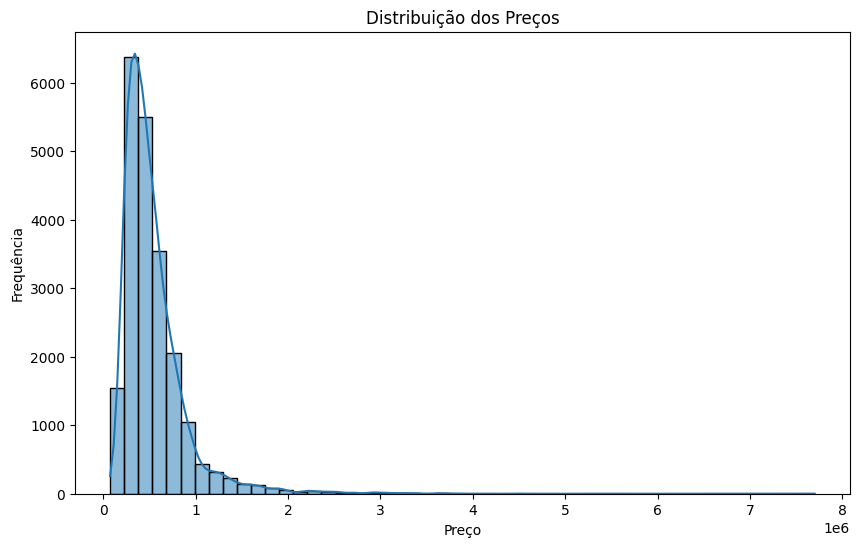

In [16]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribuição dos Preços')
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.show()

This chart shows the distribution of house prices.

The graph exhibits a highly right-skewed distribution, also known as a long right tail. Most house prices are concentrated in a lower range (closer to zero), with a gradual decline toward the right, where the highest values are located.

🔹 Most houses fall within a lower price range, primarily below $1 million (1e6 on the x-axis), indicating that the majority of properties in this dataset are more affordable.

🔹 Outliers: The long right tail suggests the presence of extreme values (outliers), likely luxury properties or houses in high-value areas. These outliers can significantly impact the mean and standard deviation, which is crucial to consider when building machine learning models.

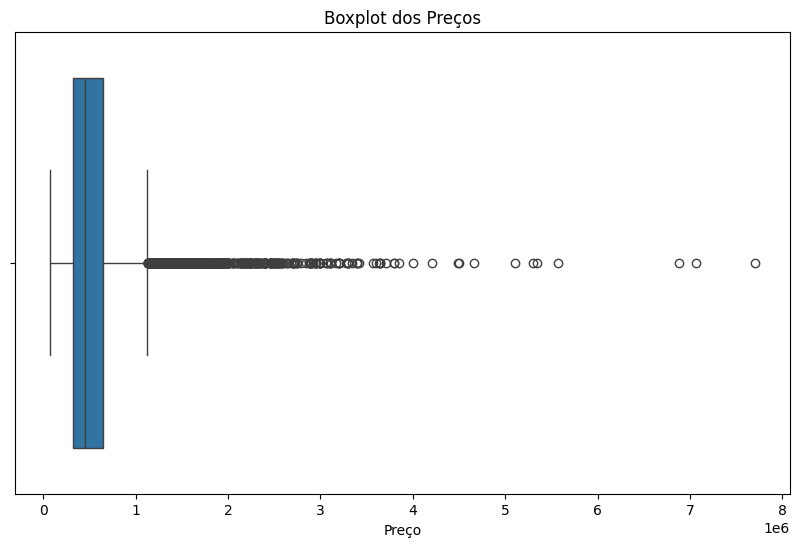

In [17]:
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'])
plt.title('Boxplot dos Preços')
plt.xlabel('Preço')
plt.show()

This boxplot illustrates the distribution of house prices and highlights the presence of many outliers.

🔹 Box (IQR - Interquartile Range):
The box in the middle represents the interquartile range (IQR), spanning from the first quartile (Q1 - 25%) to the third quartile (Q3 - 75%). The line inside the box is the median (central value). This indicates that most house prices are concentrated in a relatively narrow range, positioned toward the left side of the chart.

🔹 Whiskers (Vertical Lines):
The whiskers extend to capture data points that are not considered outliers, reaching:

- Lower bound: Q1 - 1.5 × IQR
- Upper bound: Q3 + 1.5 × IQR

🔹 Outliers (Dots Beyond the Box):
The circles to the right of the box represent outliers—house prices that exceed the expected range. In this case, many outliers are scattered across a wide price range, reaching values as high as $8 million.

Next Steps:

✅ Investigate Outliers: Check if these values make sense in the dataset’s context (e.g., luxury homes, waterfront properties) or if they indicate data entry errors.

✅ Handle Outliers: If they are meaningful, you may keep them for modeling. If they are noise or errors, consider removing or transforming them for better analysis and model performance. 


## Eliminating Noise

As observed earlier, the bathrooms column contains a minimum value of 0, which is unusual since a house is expected to have at least one bathroom.

This is likely an anomaly, so we will check how many houses have 0 bathrooms and remove them from the dataset.

In [20]:
# Count the number of houses with 0 bathrooms
zero_bathrooms_count = df[df['bathrooms'] == 0].shape[0]
print(f"Número de casas com 0 banheiros: {zero_bathrooms_count}")

Número de casas com 0 banheiros: 0


In [21]:
# Remove houses with 0 bathrooms
df = df[df['bathrooms'] != 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21603 entries, 1 to 21612
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21603 non-null  Int64  
 1   date           21603 non-null  object 
 2   price          21603 non-null  float64
 3   bedrooms       21603 non-null  Int64  
 4   bathrooms      21603 non-null  float64
 5   sqft_living    21603 non-null  Int64  
 6   sqft_lot       21603 non-null  Int64  
 7   floors         21603 non-null  float64
 8   waterfront     21603 non-null  Int64  
 9   view           21603 non-null  Int64  
 10  condition      21603 non-null  Int64  
 11  grade          21603 non-null  Int64  
 12  sqft_above     21603 non-null  Int64  
 13  sqft_basement  21603 non-null  Int64  
 14  yr_built       21603 non-null  Int64  
 15  yr_renovated   21603 non-null  Int64  
 16  zipcode        21603 non-null  Int64  
 17  lat            21603 non-null  float64
 18  long       

In addition to bathrooms, we also see cases where bedrooms are equal to 0. Residential houses are expected to have at least one bedroom, so a value of 0 is likely a data entry error.

In [22]:
zero_bedrooms_count = df[df['bedrooms'] == 0].shape[0]
print(f"Número de casas com 0 quartos: {zero_bedrooms_count}")

Número de casas com 0 quartos: 6


In [24]:
# Filtering houses with 0 bedrooms and more than 1 floor
suspect_houses = df[(df['bedrooms'] == 0) & (df['floors'] > 1)]
suspect_houses

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,basement
3741,1453602309,20140805T000000,288000.0,0,1.5,1430,1650,3.0,0,0,...,0,1999,0,98125,47.7222,-122.290,1430,1650,0,0
4815,2310060040,20140925T000000,240000.0,0,2.5,1810,5669,2.0,0,0,...,0,2003,0,98038,47.3493,-122.053,1810,5685,0,0
9612,7849202299,20150218T000000,320000.0,0,2.5,1490,7111,2.0,0,0,...,0,1999,0,98065,47.5261,-121.826,1500,4675,0,0
13003,2569500210,20141117T000000,339950.0,0,2.5,2290,8319,2.0,0,0,...,0,1985,0,98042,47.3473,-122.151,2500,8751,0,0


In [25]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,basement
1,2420069251,20150225T000000,262000.0,1,0.75,520,12981,1.0,0,0,...,0,1920,0,98022,47.2082,-121.995,1340,12233,0,0
4,745000005,20140825T000000,145000.0,1,0.75,480,9750,1.0,0,0,...,0,1948,0,98146,47.4982,-122.362,1550,9924,0,0
5,1222029077,20141029T000000,265000.0,0,0.75,384,213444,1.0,0,0,...,0,2003,0,98070,47.4177,-122.491,1920,224341,0,0
6,1352300580,20141114T000000,247000.0,1,1.00,460,4120,1.0,0,0,...,0,1937,0,98055,47.4868,-122.199,990,4120,0,0
7,1822059057,20140725T000000,152000.0,2,1.00,700,13500,1.0,0,0,...,0,1920,0,98031,47.3882,-122.208,1600,10124,0,0


Considering that it has more than one floor, it doesn't make sense not to have bedrooms, since it is a residential complex.

In [26]:
# Identify indices of houses that have 0 bedrooms and more than 1 floor
indices_para_remover = df[(df['bedrooms'] == 0) & (df['floors'] > 1)].index

# Remove the identified entries from the dataset
df = df.drop(indices_para_remover)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21599 entries, 1 to 21612
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21599 non-null  Int64  
 1   date           21599 non-null  object 
 2   price          21599 non-null  float64
 3   bedrooms       21599 non-null  Int64  
 4   bathrooms      21599 non-null  float64
 5   sqft_living    21599 non-null  Int64  
 6   sqft_lot       21599 non-null  Int64  
 7   floors         21599 non-null  float64
 8   waterfront     21599 non-null  Int64  
 9   view           21599 non-null  Int64  
 10  condition      21599 non-null  Int64  
 11  grade          21599 non-null  Int64  
 12  sqft_above     21599 non-null  Int64  
 13  sqft_basement  21599 non-null  Int64  
 14  yr_built       21599 non-null  Int64  
 15  yr_renovated   21599 non-null  Int64  
 16  zipcode        21599 non-null  Int64  
 17  lat            21599 non-null  float64
 18  long       

In [78]:
# new_df = df[~((df['bedrooms'] == 0) & (df['floors'] > 1))]

# new_df.info()

I also noticed that the bedrooms column contains houses with up to 33 bedrooms, which seems unusual. Let's try to understand what's happening!

In [27]:
# Check data for houses with more than 10 bedrooms
df[df['bedrooms'] > 10]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,basement
4111,1773100755,20140821T000000,520000.0,11,3.00,3000,4960,2.0,0,0,...,600,1918,1999,98106,47.5560,-122.363,1420,4960,1,1
4898,2402100895,20140625T000000,640000.0,33,1.75,1620,6000,1.0,0,0,...,580,1947,0,98103,47.6878,-122.331,1330,4700,0,1


Logically, it doesn't make sense for a house to have 33 or 11 bedrooms but only a few bathrooms.

Additionally, having a sqft_living of 1,620 square feet with 33 bedrooms is practically impossible. This suggests a data entry error, as it would be extremely difficult to fit so many bedrooms in such a small area.

In [28]:
df = df[df['bedrooms'] < 10]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21594 entries, 1 to 21612
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21594 non-null  Int64  
 1   date           21594 non-null  object 
 2   price          21594 non-null  float64
 3   bedrooms       21594 non-null  Int64  
 4   bathrooms      21594 non-null  float64
 5   sqft_living    21594 non-null  Int64  
 6   sqft_lot       21594 non-null  Int64  
 7   floors         21594 non-null  float64
 8   waterfront     21594 non-null  Int64  
 9   view           21594 non-null  Int64  
 10  condition      21594 non-null  Int64  
 11  grade          21594 non-null  Int64  
 12  sqft_above     21594 non-null  Int64  
 13  sqft_basement  21594 non-null  Int64  
 14  yr_built       21594 non-null  Int64  
 15  yr_renovated   21594 non-null  Int64  
 16  zipcode        21594 non-null  Int64  
 17  lat            21594 non-null  float64
 18  long       

## Removing Redundant Variables

When preparing data for machine learning models, some columns may not contribute useful information or may even negatively impact model performance.

- Machine learning models learn patterns and relationships between features; an ID is random and does not influence house price or any target variable.
- If we already have a transformed feature like "renovated" (0/1), keeping the exact year may be redundant.
- If zipcode is important, we can cluster zip codes into regions instead of using them as raw numbers.


In [29]:
df_limpo = df.copy().drop(['id', 'yr_built', 'yr_renovated'], axis=1)
df_limpo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21594 entries, 1 to 21612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21594 non-null  object 
 1   price          21594 non-null  float64
 2   bedrooms       21594 non-null  Int64  
 3   bathrooms      21594 non-null  float64
 4   sqft_living    21594 non-null  Int64  
 5   sqft_lot       21594 non-null  Int64  
 6   floors         21594 non-null  float64
 7   waterfront     21594 non-null  Int64  
 8   view           21594 non-null  Int64  
 9   condition      21594 non-null  Int64  
 10  grade          21594 non-null  Int64  
 11  sqft_above     21594 non-null  Int64  
 12  sqft_basement  21594 non-null  Int64  
 13  zipcode        21594 non-null  Int64  
 14  lat            21594 non-null  float64
 15  long           21594 non-null  float64
 16  sqft_living15  21594 non-null  Int64  
 17  sqft_lot15     21594 non-null  Int64  
 18  renovated  

In [30]:
# Removing columns that don't make sense for the problem
df_limpo = df_limpo.drop(['date', 'zipcode', 'lat', 'long'], axis=1)
df_limpo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21594 entries, 1 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21594 non-null  float64
 1   bedrooms       21594 non-null  Int64  
 2   bathrooms      21594 non-null  float64
 3   sqft_living    21594 non-null  Int64  
 4   sqft_lot       21594 non-null  Int64  
 5   floors         21594 non-null  float64
 6   waterfront     21594 non-null  Int64  
 7   view           21594 non-null  Int64  
 8   condition      21594 non-null  Int64  
 9   grade          21594 non-null  Int64  
 10  sqft_above     21594 non-null  Int64  
 11  sqft_basement  21594 non-null  Int64  
 12  sqft_living15  21594 non-null  Int64  
 13  sqft_lot15     21594 non-null  Int64  
 14  renovated      21594 non-null  int64  
 15  basement       21594 non-null  int64  
dtypes: Int64(11), float64(3), int64(2)
memory usage: 3.0 MB


## Multivariate Analysis

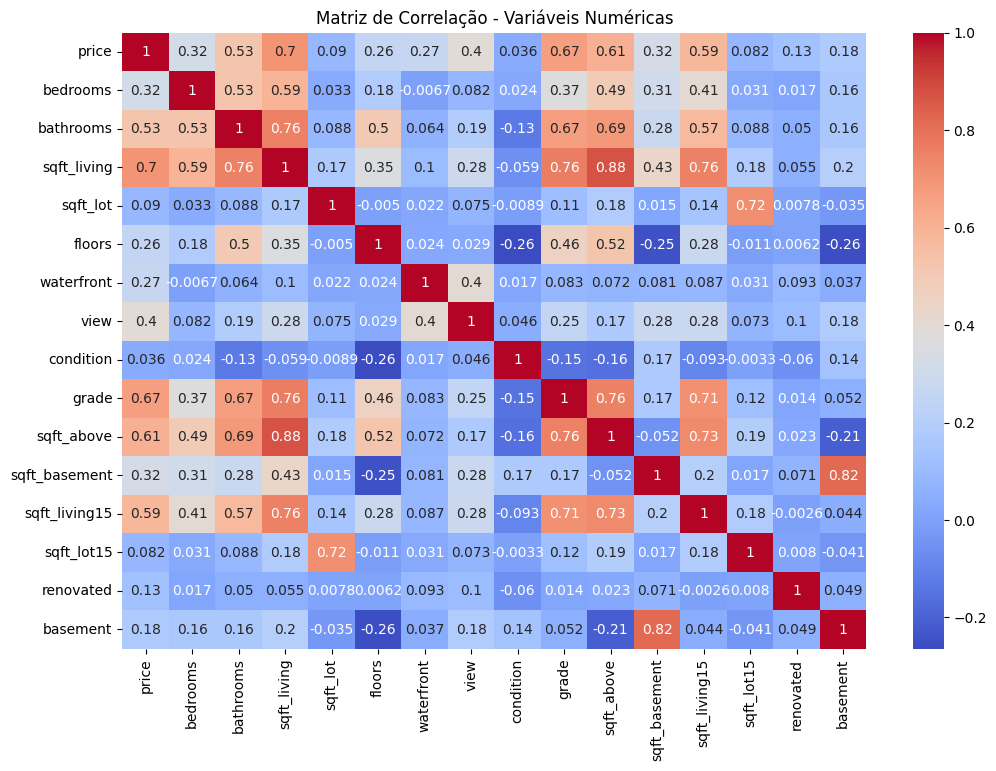

In [31]:
# Select only numeric features (float and int types)
numeric_features = df_limpo.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numeric_features.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação - Variáveis Numéricas')
plt.show()

The correlation matrix shows the degree of linear relationship between numerical variables in the dataset. The correlation values range from -1 to 1:

- +1 → Perfect positive correlation (as one variable increases, the other also increases).
- -1 → Perfect negative correlation (as one variable increases, the other decreases).
- 0 → No linear correlation (the variables are independent).


Key Correlations with price (Target Variable)
- sqft_living (0.70) → Strong positive correlation, meaning larger living areas generally lead to higher prices.
- sqft_above (0.61) → The area above ground also has a positive correlation with price.


Correlation Between Variables (Potential Redundancy)
- `sqft_living` & `sqft_above` (0.88) → Highly correlated, since most of the living space is above ground.
- `sqft_lot` & `sqft_lot15` (0.72) → Possible redundancy, as both represent lot size information.
- `sqft_basement` & `basement` (0.82) → Both indicate basement size, so keeping both might be unnecessary.

Next Steps:
- Remove highly correlated variables → Features like sqft_living and sqft_above might cause multicollinearity in regression models.

In [32]:
df_limpo.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,renovated,basement
1,262000.0,1,0.75,520,12981,1.0,0,0,5,3,520,0,1340,12233,0,0
4,145000.0,1,0.75,480,9750,1.0,0,0,2,4,480,0,1550,9924,0,0
5,265000.0,0,0.75,384,213444,1.0,0,0,3,4,384,0,1920,224341,0,0
6,247000.0,1,1.00,460,4120,1.0,0,0,3,4,460,0,990,4120,0,0
7,152000.0,2,1.00,700,13500,1.0,0,0,3,4,700,0,1600,10124,0,0


In [33]:
df_limpo.info()


<class 'pandas.core.frame.DataFrame'>
Index: 21594 entries, 1 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21594 non-null  float64
 1   bedrooms       21594 non-null  Int64  
 2   bathrooms      21594 non-null  float64
 3   sqft_living    21594 non-null  Int64  
 4   sqft_lot       21594 non-null  Int64  
 5   floors         21594 non-null  float64
 6   waterfront     21594 non-null  Int64  
 7   view           21594 non-null  Int64  
 8   condition      21594 non-null  Int64  
 9   grade          21594 non-null  Int64  
 10  sqft_above     21594 non-null  Int64  
 11  sqft_basement  21594 non-null  Int64  
 12  sqft_living15  21594 non-null  Int64  
 13  sqft_lot15     21594 non-null  Int64  
 14  renovated      21594 non-null  int64  
 15  basement       21594 non-null  int64  
dtypes: Int64(11), float64(3), int64(2)
memory usage: 3.0 MB


In [34]:
# df_limpo = df_limpo.drop(['sqft_basement'], axis=1)
# df_limpo.info()

### Removing Columns with Multicollinearity

According to the correlation matrix:

- `sqft_above`: Highly correlated with `sqft_living`. Keeping both adds redundancy.
- `sqft_living15`: Highly correlated with `sqft_living`, meaning it does not add new information.
- `sqft_lot15`: Highly correlated with `sqft_lot`, making one of them unnecessary.
- `sqft_basement`: Highly correlated with `basement`, which means they provide similar information.

In [35]:
df_limpo = df_limpo.drop(['sqft_above', 'sqft_living15', 'sqft_lot15', 'sqft_basement'], axis=1)
df_limpo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21594 entries, 1 to 21612
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21594 non-null  float64
 1   bedrooms     21594 non-null  Int64  
 2   bathrooms    21594 non-null  float64
 3   sqft_living  21594 non-null  Int64  
 4   sqft_lot     21594 non-null  Int64  
 5   floors       21594 non-null  float64
 6   waterfront   21594 non-null  Int64  
 7   view         21594 non-null  Int64  
 8   condition    21594 non-null  Int64  
 9   grade        21594 non-null  Int64  
 10  renovated    21594 non-null  int64  
 11  basement     21594 non-null  int64  
dtypes: Int64(7), float64(3), int64(2)
memory usage: 2.3 MB


Multicollinearity occurs when two or more predictor variables in a regression model are highly correlated. This means that the variables provide similar information to the model.

Problem:
- Multicollinearity makes it difficult to determine which variables truly influence the target variable.
- When variables are highly correlated, the model struggles to identify which one is more important.
- This can lead to instability in predictor coefficients, especially in linear models like linear regression.

Impact:
- Multicollinearity inflates the variance of model coefficients, making the model more sensitive to small changes in the data.
- It can reduce the model’s ability to generalize to new data, leading to poor performance in real-world applications.

## Converting Categorical Variables

In this dataset, we do not have categorical variables, as the data was already converted. However, if we had them, we could apply different encoding methods, such as one-hot encoding, label encoding, or ordinal encoding.

Categorical data in text format must be converted into numerical values using techniques like one-hot encoding, label encoding, or ordinal encoding, allowing models to learn from this information.

Converting categorical variables into numbers helps preserve the original information while ensuring proper model interpretation, preventing biases in the learning process.

# ML models

 ## Baseline Regression Model

Before exploring more complex models, it's important to establish a baseline model. In regression problems, Multiple Linear Regression is a strong starting point because it provides a clear and interpretable relationship between the input features and the target variable (price).

This model is based on the **equation of a straight line**, where the target variable is a linear combination of the input features. Each feature has a coefficient that represents its contribution to the final prediction. The goal is to find the best coefficients that minimize the difference between predicted and actual values.

By starting with this approach, we create a reference point for evaluating future models. If a more complex model does not significantly outperform this baseline, it may not justify the added complexity.

### Multiple Linear Regression

In [36]:
#Selecting Independent Variables (Features) and the Dependent Variable (Target) 
X = df_limpo[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
             'waterfront', 'view', 'grade', 'renovated', 'basement', 'condition']]

y = np.log(df['price'])  # Target variable (price)

- The features (X) include variables that may influence house prices, such as number of bedrooms, bathrooms, living area, floors, and whether the house has been renovated.
- The target variable (y) is the house price, and a logarithmic transformation (`log(price)`) is applied to normalize the distribution and improve the model’s performance.
  - Log Transformation on Price: Reduces skewness, normalizes the distribution, and minimizes the impact of extreme outliers.









In [37]:
# Splitting Data into Training and Testing Sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The dataset is split into training (80%) and testing (20%) to evaluate model performance.


In [39]:
# Scaling Data for Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

MinMaxScaler: Rescales features between 0 and 1, preventing large-scale features from dominating and improving model convergence.


In [40]:
# Creating and training the Linear Regression Model
# Initializes a linear regression model and fits it to the training data.
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)

# Making predictions on the test set
y_pred = reg.predict(X_test_scaled)

# Evaluating the Model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Displaying MSE and R²
print(f'Mean Squared Error (MSE): {mse}')
print(f'Coeficiente de Determinação (R²): {r2}')

# Comparing Predictions with Actual Values
df_result = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_pred})
print(df_result.head())

Mean Squared Error (MSE): 0.11039293160949341
Coeficiente de Determinação (R²): 0.594661714338611
       Actual Price  Predicted Price
3690      13.758940        13.033181
11825     12.860999        13.104840
4042      12.936034        12.828325
3441      12.959844        12.800599
19306     13.244581        13.173498


In [41]:
# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'MAPE: {mape:.2f}%')

MAPE: 2.05%


- MSE (Mean Squared Error): Measures the average squared error between actual values (y_test) and predicted values (y_pred). A value of 0.11 seems reasonable, especially since y was transformed using the natural logarithm.
- R² (Coefficient of Determination): Measures the proportion of variance in the data explained by the model. A value of 1 indicates that the model perfectly explains the data. A value of 0 means the model does not explain any variance. Negative values are possible and suggest the model may be performing poorly. With 0.59, the model explains 59% of the variance in the data, which is reasonable but not excellent.
- MAPE (Mean Absolute Percentage Error): Measures the average absolute percentage error between actual values (y_test) and predicted values (y_pred). A MAPE of 2.05% indicates that, on average, the model’s predictions deviate by about 2.02% from the actual values.

**When working with machine learning models, achieving 100% accuracy is extremely rare and often a sign that something is wrong. It could indicate overfitting, meaning the model has learned the training data too well, including noise and specific patterns that do not generalize to new data.**

In real-world scenarios, a good model balances accuracy and generalization. A high R² score (e.g., 0.90 or higher) may be great, but a perfect 1.0 should raise concerns about potential data leakage, overly complex models, or issues in preprocessing.

### Cross-validation

Cross-validation is a technique used to evaluate the performance and generalization of a machine learning model by dividing the dataset into multiple subsets. The most common method is k-fold cross-validation, where the data is split into k folds:

The model is trained on k-1 folds and tested on the remaining fold.
This process is repeated k times, each time using a different fold for testing.
The final performance is the average of the results across all folds, giving a more reliable estimate of how the model will perform on unseen data.

In [42]:
# Selecting the independent variables (features) and the dependent variable (target)
X = df_limpo[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
              'waterfront', 'view', 'grade', 'renovated','basement', 'condition']]
y = np.log(df_limpo['price'])   # Target variable (price)

# Scaling the data for normalization
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Scaling the entire dataset

# Creating the linear regression model
reg = LinearRegression()

# Defining the number of folds for cross-validation (e.g., 5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Calculating MSE and R² using cross-validation
mse_scorer = make_scorer(mean_squared_error)
r2_scorer = make_scorer(r2_score)

mse_scores = cross_val_score(reg, X_scaled, y, cv=kf, scoring=mse_scorer)
r2_scores = cross_val_score(reg, X_scaled, y, cv=kf, scoring=r2_scorer)

# Displaying the mean and standard deviation of the validation metrics
print(f'MSE (cross-validation): {mse_scores.mean()} ± {mse_scores.std()}')
print(f'R² (cross-validation): {r2_scores.mean()} ± {r2_scores.std()}')

MSE (validação cruzada): 0.10878734095975125 ± 0.0011079244698675133
R² (validação cruzada): 0.6067730784762608 ± 0.014272867366762965


- The cross-validation process slightly improved the model’s performance.
- The lower MSE and higher R² suggest the model generalizes better.
- The validation also ensures we are not overfitting to a single train-test split (cross-validation helps prevent overfitting by ensuring the model is tested on different subsets of data rather than relying on a single train-test split)

### Using GridSearch


GridSearchCV is a method used to find the best hyperparameters for a machine learning model by systematically testing multiple parameter combinations.

Why Not Execute It Now?

- Computationally Expensive – GridSearch tests every possible combination, which can take a long time, especially for large datasets.
- Performance Impact – Running GridSearch on complex models can significantly slow down performance, making it impractical in some cases.

How GridSearch Works?
- Define a Set of Hyperparameters – Specify different values for parameters like learning rate, number of neighbors (for KNN), or tree depth (for decision trees).
- Train Models on Each Combination – GridSearch fits multiple models using cross-validation to evaluate performance.
- Select the Best Parameters – It returns the combination that optimizes the chosen metric (e.g., accuracy, MSE, R²).

In [ ]:
# # Base Model
# ridge = Ridge()

# # Hyperparameter Grid
# param_grid = {
#     'alpha': [0.001, 0.01, 0.1, 1, 10, 100],  # Valores de regularização
#     'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg']  # Diferentes solvers
# }

# # Configuring Grid Search with Cross-Validation
# grid_search = GridSearchCV(
#     estimator=ridge,
#     param_grid=param_grid,
#     scoring='neg_mean_squared_error',  # Using MSE as the metric
#     cv=5,  # 5-fold cross-validation
#     verbose=1,
#     n_jobs=-1  # Use all available cores to speed up computation
# )

# # Fitting Grid Search on Training Data
# grid_search.fit(X_train_scaled, y_train)

# # Grid Search Results
# print("Melhores parâmetros:", grid_search.best_params_)
# print("Melhor score (MSE negativo):", grid_search.best_score_)

# # Best Model Found
# best_ridge = grid_search.best_estimator_

# # Predictions on the Test Set
# y_pred = best_ridge.predict(X_test_scaled)

# # Evaluating on the Test Set
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print(f"RMSE no conjunto de teste: {rmse}")

## XGBoost

XGBoost (Extreme Gradient Boosting) is a powerful machine learning algorithm optimized for performance and efficiency. It is based on gradient boosting, where multiple weak decision tree models are sequentially trained to correct the errors of previous models. XGBoost is widely used due to its high accuracy, speed, and ability to handle large datasets efficiently.


In [98]:
# Configuring the model with initial hyperparameters
xgb_model = XGBRegressor(
    n_estimators=100,          # Number of trees
    max_depth=5,               # Maximum depth of trees
    learning_rate=0.1,         # Learning rate
    subsample=0.8,             # Proportion of data used in each tree
    colsample_bytree=0.8,      # Proportion of features used per tree
    random_state=42,           # Ensures reproducibility
    objective='reg:squarederror'  # Error function for regression
    

# Training the model
xgb_model.fit(X_train_scaled, y_train)

# Making predictions on the test set
y_pred = xgb_model.predict(X_test_scaled)


# Evaluating the model with different metrics
rmse = mean_squared_error(y_test, y_pred)  # RMSE
mse = mean_squared_error(y_test, y_pred)                 # MSE
mae = mean_absolute_error(y_test, y_pred)               # MAE
r2 = r2_score(y_test, y_pred)                           # R²
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # MAPE

# Displaying the metrics
print(f"RMSE (Root Mean Squared Error): {rmse}")
print(f"MSE (Mean Squared Error): {mse}")
print(f"MAE (Mean Absolute Error): {mae}")
print(f"R² (Coeficiente de Determinação): {r2}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

RMSE (Root Mean Squared Error): 0.09511921850716062
MSE (Mean Squared Error): 0.09511921850716062
MAE (Mean Absolute Error): 0.24439245786340036
R² (Coeficiente de Determinação): 0.6507433908945316
MAPE (Mean Absolute Percentage Error): 1.88%


- RMSE (Root Mean Squared Error): The model has an average error of around 0.302 on the target variable's scale. Lower values are better, indicating that predictions are closer to actual values.
- MSE (Mean Squared Error): MSE is the average squared error, making it more sensitive to large deviations (outliers).
- MAE (Mean Absolute Error): MAE represents the average absolute error without penalizing larger errors as RMSE does. This means that, on average, the model is making an error of 0.239 in the target variable's unit.
- R² (Coefficient of Determination): R² measures the proportion of variance explained by the model. With 67.2%, the model explains a significant part of the data variance, but there is room for improvement.
- MAPE (Mean Absolute Percentage Error): Indicates that, on average, the model has an error of 1.84% relative to actual values.

### Feature importance

In [99]:
# Certifique-se de que X_train é um DataFrame com colunas nomeadas
feature_names = X_train.columns.tolist()

# Atualizando os nomes das features no modelo XGBoost
xgb_model.get_booster().feature_names = feature_names

<Figure size 1000x800 with 0 Axes>

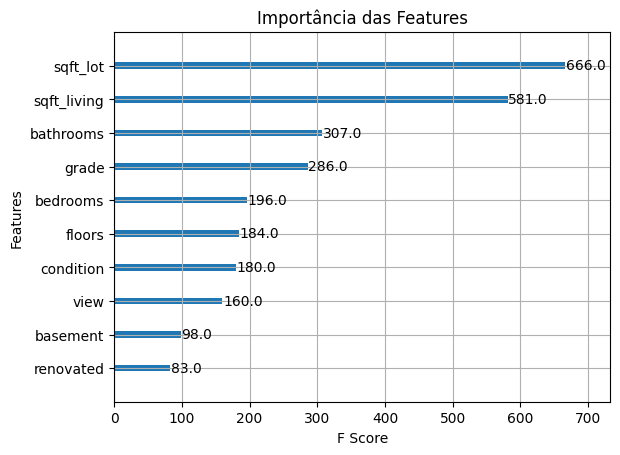

In [100]:
# Plotar a importância das features
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=10, importance_type='weight', xlabel='F Score')
plt.title('Importância das Features')
plt.show()

Feature importance helps us understand which variables have the greatest impact on the model’s predictions. In this case, we are using the F Score (weight), which indicates how many times a feature was used to split data across all trees in the XGBoost model.

Key Takeaways from the Plot:
- `sqft_lot` and `sqft_living` are the most important features, meaning they were frequently used by the model to make decisions. This makes sense, as the size of the lot and the living area are strong indicators of house price.
- `bathrooms` and `grade` also play significant roles, showing that the number of bathrooms and the overall quality of the house (grade) contribute significantly to price prediction.
- `bedrooms`, `floors`, and `condition` have moderate importance, indicating they still affect the model but are less decisive than the previous features.
- `view`, `basement`, and `renovated` have lower importance, suggesting that while they do influence house prices, they are not as critical in decision-making compared to other features.

Why is this useful?
- Feature Selection: If some features have very low importance, we might consider removing them to simplify the model and improve efficiency.
- Model Interpretability: Understanding which variables drive the predictions helps in making data-driven decisions.
- Bias and Overfitting: If a feature is highly dominant, it might indicate a potential data bias that could lead to overfitting.

### Using GridSearchCV


In [ ]:
# # Modelo base
# xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# # Definindo o grid de hiperparâmetros
# param_grid = {
#     'n_estimators': [100, 200, 300],        # Número de árvores
#     'max_depth': [3, 5, 7],                # Profundidade máxima
#     'learning_rate': [0.01, 0.1, 0.2],     # Taxa de aprendizado
#     'subsample': [0.8, 1.0],               # Proporção dos dados usada em cada árvore
#     'colsample_bytree': [0.8, 1.0],        # Proporção de features usadas por árvore
#     'reg_alpha': [0, 0.1, 1],              # Regularização L1
#     'reg_lambda': [1, 10],                 # Regularização L2
# }

# # Configurando o GridSearchCV
# grid_search = GridSearchCV(
#     estimator=xgb,                  # Modelo a ser ajustado
#     param_grid=param_grid,          # Grid de hiperparâmetros
#     scoring='neg_mean_squared_error',  # Métrica de avaliação
#     cv=5,                           # Validação cruzada (5-fold)
#     verbose=1,                      # Exibe progresso
#     n_jobs=-1                       # Paralelismo para acelerar
# )

# # Ajustando o Grid Search nos dados escalados
# grid_search.fit(X_train_scaled, y_train)

# # Melhor combinação de hiperparâmetros
# print("Melhores parâmetros:", grid_search.best_params_)

# # Melhor score na validação cruzada
# print("Melhor score (MSE negativo):", grid_search.best_score_)

# # Avaliação do modelo com os melhores hiperparâmetros no conjunto de teste
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test_scaled)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print("RMSE no conjunto de teste:", rmse)

## GBR Model


In [43]:
# Configurando o modelo com hiperparâmetros iniciais
gbr_model = GradientBoostingRegressor(
    n_estimators=100,          # Número de árvores
    max_depth=5,               # Profundidade máxima das árvores
    learning_rate=0.1,         # Taxa de aprendizado
    subsample=0.8,             # Proporção dos dados usados em cada árvore
    random_state=42            # Para resultados reproduzíveis
)

# Treinando o modelo
gbr_model.fit(X_train_scaled, y_train)

# Fazendo previsões no conjunto de teste
y_pred = gbr_model.predict(X_test_scaled)

# Avaliando o modelo com diferentes métricas
rmse = mean_squared_error(y_test, y_pred)  # RMSE
mse = mean_squared_error(y_test, y_pred)                 # MSE
mae = mean_absolute_error(y_test, y_pred)               # MAE
r2 = r2_score(y_test, y_pred)                           # R²
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # MAPE

# Exibindo as métricas
print(f"RMSE (Root Mean Squared Error): {rmse}")
print(f"MSE (Mean Squared Error): {mse}")
print(f"MAE (Mean Absolute Error): {mae}")
print(f"R² (Coeficiente de Determinação): {r2}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

RMSE (Root Mean Squared Error): 0.09575800996900015
MSE (Mean Squared Error): 0.09575800996900015
MAE (Mean Absolute Error): 0.24547974461330807
R² (Coeficiente de Determinação): 0.6483978907591326
MAPE (Mean Absolute Percentage Error): 1.89%


The R² score has improved compared to previous models, reaching approximately 0.648, meaning the model can now explain about 64.8% of the variance in the data. While this is an improvement, it is still not optimal.

At this point, there are several possible next steps to further enhance the model’s performance:

- Try different models: Experiment with other machine learning algorithms that might better capture the relationships in the data.
- Tune hyperparameters: Adjust key parameters to find the best configuration for the selected model.
- Use more performant models: Consider more complex models like ensemble methods or deep learning if applicable.
- Review feature engineering: Analyze and refine the selection and transformation of features to ensure the model is learning from the most relevant information.
- Improve data preprocessing: Handle potential outliers, missing values, and scaling techniques to enhance data quality.
- Conduct further data analysis: Investigate correlations, distributions, and potential hidden patterns that could inform model adjustments.

Machine learning is an iterative process of experimentation, where continuous refinement and testing lead to better models.

### Gridsearch


In [104]:
# # Modelo base para Gradient Boosting
# gbr = GradientBoostingRegressor(random_state=42)

# # Definindo o grid de hiperparâmetros
# param_grid_gbr = {
#     'n_estimators': [100, 200, 300],        # Número de árvores
#     'max_depth': [3, 5, 7],                # Profundidade máxima
#     'learning_rate': [0.01, 0.1, 0.2],     # Taxa de aprendizado
#     'subsample': [0.8, 1.0],               # Proporção dos dados usada em cada árvore
#     'min_samples_split': [2, 5, 10],       # Número mínimo de amostras para dividir um nó
#     'min_samples_leaf': [1, 2, 4],         # Número mínimo de amostras em uma folha
# }

# # Configurando o GridSearchCV
# grid_search_gbr = GridSearchCV(
#     estimator=gbr,                  # Modelo a ser ajustado
#     param_grid=param_grid_gbr,      # Grid de hiperparâmetros
#     scoring='neg_mean_squared_error',  # Métrica de avaliação
#     cv=5,                           # Validação cruzada (5-fold)
#     verbose=1,                      # Exibe progresso
#     n_jobs=-1                       # Paralelismo para acelerar
# )

# # Ajustando o Grid Search nos dados escalados
# grid_search_gbr.fit(X_train_scaled, y_train)

# # Melhor combinação de hiperparâmetros
# print("Melhores parâmetros:", grid_search_gbr.best_params_)

# # Melhor score na validação cruzada
# print("Melhor score (MSE negativo):", grid_search_gbr.best_score_)

# # Avaliação do modelo com os melhores hiperparâmetros no conjunto de teste
# best_gbr = grid_search_gbr.best_estimator_
# y_pred_gbr = best_gbr.predict(X_test_scaled)

# # Calculando métricas
# rmse = mean_squared_error(y_test, y_pred_gbr, squared=False)  # RMSE
# mae = mean_absolute_error(y_test, y_pred_gbr)                # MAE
# mape = np.mean(np.abs((y_test - y_pred_gbr) / y_test)) * 100  # MAPE
# r2 = r2_score(y_test, y_pred_gbr)                            # R²

# # Exibindo métricas
# print(f"RMSE no conjunto de teste: {rmse:.4f}")
# print(f"MAE no conjunto de teste: {mae:.4f}")
# print(f"MAPE no conjunto de teste: {mape:.2f}%")
# print(f"R² no conjunto de teste: {r2:.4f}")

# Saving Models (Serialization) in Cloud Storage

Model serialization is the process of saving a trained model to a file so it can be reused later without needing to be retrained. This is useful because training a model can be time-consuming and require significant computational resources. With serialization, we can save the trained model and quickly load it later for future predictions.


The model is saved as a binary file using libraries like `joblib` or `pickle`. This file contains:

- The model’s weights (coefficients in regression, trees in decision tree models, etc.).
- The model’s hyperparameters, if applicable.
- Any transformations applied to the data, such as normalization or logarithmic conversion.


In [105]:
pip install joblib


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [108]:
from joblib import dump
from google.cloud import storage
import os

In [110]:
# Defining the local file name
local_file = "model_pipeline.joblib"

# Creating a dictionary with the model and transformations
pipeline = {
    'model': gbr_model,      # The trained model
    'scaler': scaler,        # The X normalizer
    'y_transform': 'log',    # Information about the transformation applied to y
}

# # Saving the pipeline locally
# dump(pipeline, local_file)
# print("Modelo e pipeline serializados localmente.")

Modelo e pipeline serializados localmente.


In [111]:
# Define the bucket name and file path in GCS
bucket_name = "talk-gdg"  # Replace with your bucket name
destination_blob_name = "models/model_pipeline.joblib"  # Path in GCS

# Create the Cloud Storage client
storage_client = storage.Client()

# Access the bucket
bucket = storage_client.bucket(bucket_name)

# Create a blob (file in GCS)
blob = bucket.blob(destination_blob_name)

# Upload the file to GCS
blob.upload_from_filename(local_file)

print(f"Model successfully saved in gs://{bucket_name}/{destination_blob_name}")

Modelo salvo com sucesso em gs://talk-gdg/models/model_pipeline.joblib
